In [1]:
import numpy as np
import pandas as pd
import math

import itertools

import os
import sys
sys.path.insert(0, "../")

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from plotWafer import plotWafer
from train import emd


arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])

In [2]:
f_raw = '../data/signal/nElinks_5/ttbar_v11_eolNoise_Layer9_5Links.csv'

# if data not found, download from dropbox
if not os.path.isfile(f_raw):
    os.system('cd ../; wget -O data.tgz https://www.dropbox.com/s/owdfdxwb9rwrgyo/data.tgz?dl=1; tar -xvzf data.tgz; rm data.tgz')

calQ     = np.genfromtxt(f_raw, delimiter=',',usecols=[*range(0, 48)],skip_header=2000,max_rows=300)
sumQ     = calQ.sum(axis=1)
calQ     = calQ[sumQ>0]
sumQ     = sumQ[sumQ>0]
occ = (np.count_nonzero(calQ>1,axis=1))

# reshape into 443 and normalize (as is usually done for autoencoder)
calQ_443 = (calQ/np.expand_dims(sumQ,-1))[:,arrange443].reshape(-1,4,4,3)

# split train and validation so there is no overlap in samples whatsoever
train_indices = range(0, int(0.6*len(calQ)))
val_indices = range(int(0.6*len(calQ)), len(calQ))

idx1_train = np.array([i for i,j in itertools.product(train_indices,train_indices)])
idx2_train = np.array([j for i,j in itertools.product(train_indices,train_indices)])

use443 = True
if use443: 
    X = calQ_443
else:
    X = calQ
X1_train = X[idx1_train]
X2_train = X[idx2_train]
y_train = np.array([emd(X[i],X[j]) for i, j in zip(idx1_train, idx2_train)])

idx1_val = np.array([i for i,j in itertools.product(val_indices,val_indices)])
idx2_val = np.array([j for i,j in itertools.product(val_indices,val_indices)])

X1_val = X[idx1_val]
X2_val = X[idx2_val]
y_val = np.array([emd(X[i],X[j]) for i, j in zip(idx1_val, idx2_val)])

print(X1_train.shape)
print(X2_train.shape)
print(y_train.shape)

print(X1_val.shape)
print(X2_val.shape)
print(y_val.shape)


(25600, 4, 4, 3)
(25600, 4, 4, 3)
(25600,)
(11664, 4, 4, 3)
(11664, 4, 4, 3)
(11664,)


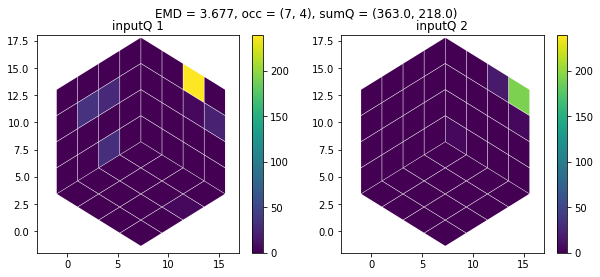

In [3]:

%matplotlib inline
i = 10
j = 13

fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].set(title='inputQ 1')
axs[1].set(title='inputQ 2')
minQ = min(min(calQ[i]),min(calQ[j]))
maxQ = max(max(calQ[i]),max(calQ[j]))
plotWafer(calQ[i], fig, axs[0], scale=(minQ,maxQ))
plotWafer(calQ[j], fig, axs[1], scale=(minQ,maxQ))
fig.suptitle('EMD = %.3f, occ = (%s, %s), sumQ = (%s, %s)'%(emd(calQ[i],calQ[j]),occ[i],occ[j], sumQ[i], sumQ[j]))
plt.show()

In [4]:
import tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, BatchNormalization, Activation, Average, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2


if use443:
    # make a convolutional model as a more advanced PoC
    input1 = Input(shape=(4, 4, 3,), name='input_1')
    input2 = Input(shape=(4, 4, 3,), name='input_2')
    x = Concatenate(name='concat')([input1, input2])
    x = Conv2D(128, 3, strides=(1, 1), name='conv2d_1', padding='same', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_1')(x)
    x = Activation('relu', name='relu_1')(x)
    x = Conv2D(128, 3, strides=(1, 1), name='conv2d_2', padding='same', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_2')(x)
    x = Activation('relu', name='relu_2')(x)
    x = Conv2D(128, 3, strides=(1, 1), name='conv2d_3', padding='same', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_3')(x)
    x = Activation('relu', name='relu_3')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(128, name='dense_1', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_4')(x)
    x = Activation('relu', name='relu_4')(x)
    output = Dense(1, name='output')(x)
    model = Model(inputs=[input1, input2], outputs=output, name='base_model')
    model.summary()
else:
    # make a simple fully connected model as a PoC
    input1 = Input(shape=(48,), name='input_1')
    input2 = Input(shape=(48,), name='input_2')
    x = Concatenate(name='concat')([input1, input2])
    x = Flatten(name='flatten')(x)
    x = Dense(128, name='dense_1', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_1')(x)
    x = Activation('relu', name='relu_1')(x)
    x = Dense(128, name='dense_2', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_2')(x)
    x = Activation('relu', name='relu_2')(x)
    x = Dense(128, name='dense_3', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_3')(x)
    x = Activation('relu', name='relu_3')(x)
    output = Dense(1, name='output')(x)
    model = Model(inputs=[input1, input2], outputs=output, name='base_model')
    model.summary()

# make a model that enforces the symmetry of the EMD function by averging the outputs for swapped inputs
output = Average(name='average')([model((input1, input2)), model((input2, input1))])
sym_model = Model(inputs=[input1, input2], outputs=output, name='sym_model')
sym_model.summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 4, 4, 6)      0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 128)    7040        concat[0][0]            

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
!mkdir -p models
callbacks = [ModelCheckpoint('models/emd_model_best.h5', monitor='val_loss', verbose=1, save_best_only=True),
             ModelCheckpoint('models/emd_model_last.h5', monitor='val_loss', verbose=1, save_last_only=True),
            ]
    
sym_model.compile(optimizer='adam', loss='msle', metrics=['mse', 'mae', 'mape', 'msle'])
history = sym_model.fit((X1_train, X2_train), y_train, 
                    validation_data=((X1_val, X2_val), y_val),
                    epochs=20, verbose=1, batch_size=32, callbacks=callbacks)

Epoch 1/20
800/800 [==============================] - 12s 11ms/step - loss: 0.5369 - mse: 23.6680 - mae: 2.5912 - mape: 20561885.2813 - msle: 0.4844 - val_loss: 0.0768 - val_mse: 1.1494 - val_mae: 0.8449 - val_mape: 4604259.5000 - val_msle: 0.0316

Epoch 00001: val_loss improved from inf to 0.07676, saving model to models/emd_model_best.h5

Epoch 00001: saving model to models/emd_model_last.h5
Epoch 2/20
800/800 [==============================] - 8s 10ms/step - loss: 0.0552 - mse: 0.5167 - mae: 0.5595 - mape: 3941943.5095 - msle: 0.0139 - val_loss: 0.0448 - val_mse: 0.5433 - val_mae: 0.5742 - val_mape: 3650655.7500 - val_msle: 0.0142

Epoch 00002: val_loss improved from 0.07676 to 0.04478, saving model to models/emd_model_best.h5

Epoch 00002: saving model to models/emd_model_last.h5
Epoch 3/20
800/800 [==============================] - 7s 9ms/step - loss: 0.0390 - mse: 0.4501 - mae: 0.5254 - mape: 3208841.3586 - msle: 0.0114 - val_loss: 0.0361 - val_mse: 0.6718 - val_mae: 0.6525 - val

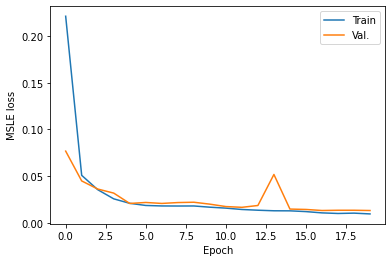

In [10]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val.')
plt.xlabel('Epoch')
plt.ylabel('MSLE loss')
plt.legend()

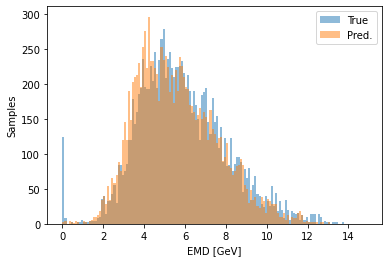

In [7]:
y_val_preds = sym_model.predict((X1_val, X2_val))
plt.figure()
plt.hist(y_val, alpha=0.5, bins=np.arange(0, 15, 0.1), label='True')
plt.hist(y_val_preds, alpha=0.5, bins=np.arange(0, 15, 0.1), label='Pred.')
plt.xlabel('EMD [GeV]')
plt.ylabel('Samples')
plt.legend()
plt.show()

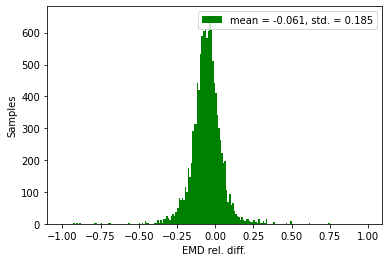

In [8]:
rel_diff = (y_val_preds[y_val>0].flatten()-y_val[y_val>0].flatten())/y_val[y_val>0].flatten()
plt.figure()
plt.hist(rel_diff, bins=np.arange(-1, 1, 0.01), color='green', label = 'mean = {:.3f}, std. = {:.3f}'.format(np.mean(rel_diff), np.std(rel_diff)))
plt.xlabel('EMD rel. diff.')
plt.ylabel('Samples')
plt.legend()
plt.show()

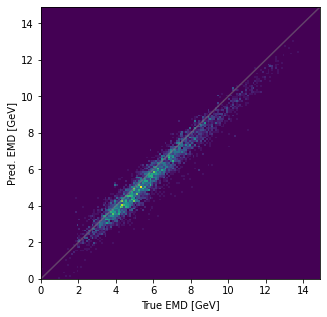

In [9]:
fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.arange(0, 15, 0.1)
y_bins = np.arange(0, 15, 0.1)
plt.hist2d(y_val.flatten(), y_val_preds.flatten(), bins=[x_bins,y_bins])
plt.plot([0, 15], [0, 15], color='gray', alpha=0.5)
ax.set_xlabel('True EMD [GeV]')
ax.set_ylabel('Pred. EMD [GeV]')
plt.show()